In [1]:
from stacked_mnist import *
from verification_net import VerificationNet
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torch.optim as optim
from autoencoder import Autoencoder
from util import *

In [2]:
# GLOBALS
BATCH_SIZE = 1024
EPOCHS = 15
NUM_CHANNELS = 1


In [3]:
_train_data = StackedMNISTData(mode=DataMode.COLOR_BINARY_MISSING)
_test_data = StackedMNISTData(mode=DataMode.COLOR_BINARY_COMPLETE)

train_dataset = _train_data.get_full_data_set(training=True)
test_dataset = _test_data.get_full_data_set(training=False)

In [5]:
train_dataset[0].__len__()

54149

In [6]:
class StackedMnistDataset(Dataset):
    def __init__(self, data):
        self.X = torch.from_numpy(data[0]).float()
        self.y = torch.from_numpy(data[1]).float()
        # turn them into long tensors
        self.y = self.y.long()
        

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [7]:
stacked_mnist_train = StackedMnistDataset(train_dataset)
stacked_mnist_test = StackedMnistDataset(test_dataset)

train_loader = DataLoader(stacked_mnist_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(stacked_mnist_test, batch_size=1, shuffle=False)

In [8]:
for x, y in train_loader:
    # reshape to (batch_size, num_channels, height, width)
    #x = x.reshape(-1, 3, 28, 28)
    print(x.shape)
    print(y.shape)
    break

torch.Size([1024, 28, 28, 3])
torch.Size([1024])


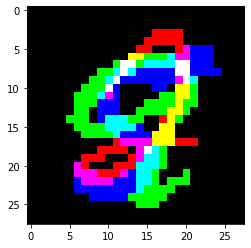

In [7]:
#plt.imshow(next(iter(train_loader))[0][3])
plt.imshow(next(iter(train_loader))[0][0])

In [11]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")
# model = Autoencoder()

try:
    model = torch.load("./models/color_anom_autoencoder", map_location=device)
    model.to(device)
    criterion = nn.BCELoss()
    print("Loaded model from file")

except:
    print("couldnt load")

device: cuda
Loaded model from file


In [9]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")
model = Autoencoder()
criterion = nn.BCELoss()
# criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

model.to(device)

device: cuda


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=64, out_features=32, bias=True)
    (11): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.2)
    (13): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32

In [10]:
def train(epochs=EPOCHS, force_retrain=False):

    # try to load the model if it exists and force_retrain is False
    if not force_retrain:
        try:
            checkpoint = torch.load("./models/stacked_anom_autoencoder.pth")
            model.load_state_dict(checkpoint["model_state_dict"])
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
            start_epoch = checkpoint["epoch"] + 1
            print("Loaded checkpoint from epoch", start_epoch)
        except:
            start_epoch = 0
            print("Starting from scratch")
    else:
        start_epoch = 0
        print("Starting from scratch (forced retrain)")

    # train the model
    outputs = []
    model.train()
    for epoch in range(start_epoch, epochs):
        for im, _ in train_loader:
            num_channels = im.shape[-1]
            im = im.reshape(-1, num_channels, 28, 28)
            im = im.to(device)
            # ===================forward=====================
            output = model(im)
            output = output.squeeze().reshape(-1, num_channels, 28, 28)
            loss = criterion(output, im)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, EPOCHS, loss.item()))
        outputs.append((epoch, im, output))

        # save the model
    if outputs:
        checkpoint = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }
        torch.save(checkpoint, "./models/stacked_anom_autoencoder.pth")

    return outputs

In [11]:
EPOCHS = 100
train_outputs = train(epochs=EPOCHS, force_retrain=True)

Starting from scratch (forced retrain)
epoch [1/100], loss:0.3432
epoch [2/100], loss:0.2489
epoch [3/100], loss:0.2049
epoch [4/100], loss:0.1846
epoch [5/100], loss:0.1734
epoch [6/100], loss:0.1660
epoch [7/100], loss:0.1606
epoch [8/100], loss:0.1596
epoch [9/100], loss:0.1553
epoch [10/100], loss:0.1525
epoch [11/100], loss:0.1514
epoch [12/100], loss:0.1493
epoch [13/100], loss:0.1489
epoch [14/100], loss:0.1460
epoch [15/100], loss:0.1450
epoch [16/100], loss:0.1443
epoch [17/100], loss:0.1417
epoch [18/100], loss:0.1441
epoch [19/100], loss:0.1433
epoch [20/100], loss:0.1426
epoch [21/100], loss:0.1423
epoch [22/100], loss:0.1419
epoch [23/100], loss:0.1404
epoch [24/100], loss:0.1411
epoch [25/100], loss:0.1402
epoch [26/100], loss:0.1389
epoch [27/100], loss:0.1382
epoch [28/100], loss:0.1375
epoch [29/100], loss:0.1380
epoch [30/100], loss:0.1372
epoch [31/100], loss:0.1374
epoch [32/100], loss:0.1373
epoch [33/100], loss:0.1364
epoch [34/100], loss:0.1369
epoch [35/100], lo

In [12]:
torch.save(model, "./models/color_anom_autoencoder")

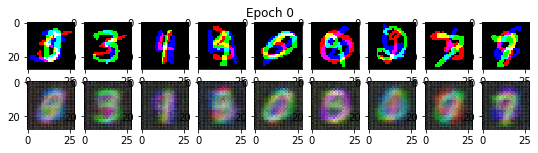

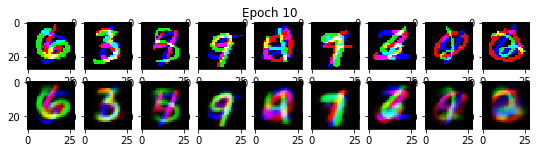

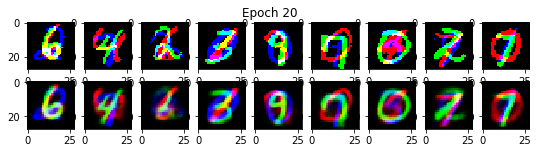

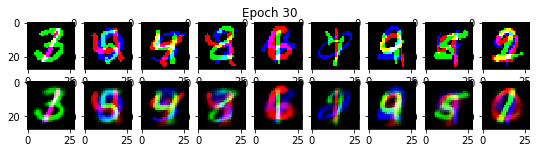

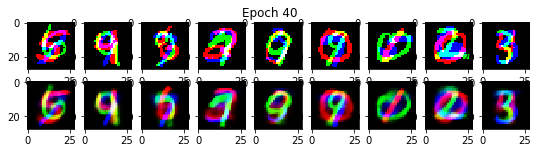

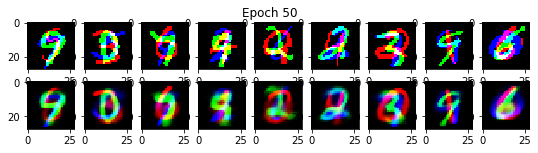

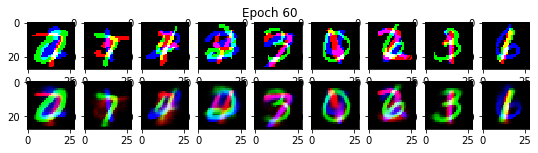

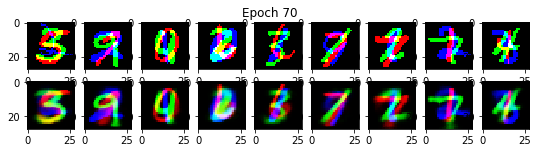

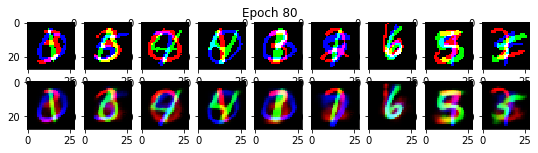

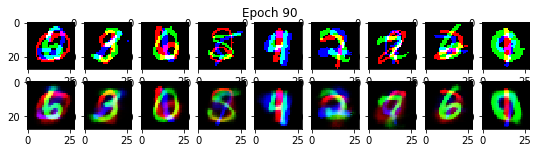

In [13]:
if train_outputs:
    # ensure 10 iterations
    desired_iterations = 10
    num_train_outputs = len(train_outputs)
    step = max(num_train_outputs // desired_iterations, 1)
    
    for k in range(0, EPOCHS, step):
        plt.figure(figsize=(9, 2))
        plt.gray()

        imgs = train_outputs[k][1].reshape(-1, 28, 28, 3).detach().cpu().numpy()
        recon = train_outputs[k][2].reshape(-1, 28, 28, 3).detach().cpu().numpy()

        for i, item in enumerate(imgs):
            if i >= 9:
                break
            plt.subplot(2, 9, i + 1)
            plt.imshow(item)

        for i, item in enumerate(recon):
            if i >= 9:
                break
            plt.subplot(2, 9, 9 + i + 1)
            plt.imshow(item)

        plt.suptitle(f"Epoch {k}")

100%|██████████| 10000/10000 [00:28<00:00, 347.90it/s]


Text(0, 0.5, 'Count')

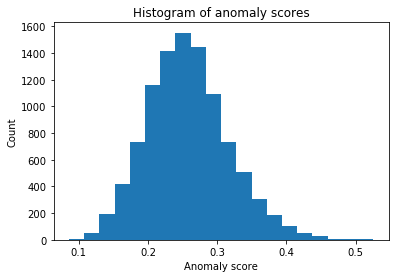

In [12]:
# do anomaly detection

model.eval()

anom_scores = []
for im, label in tqdm(test_loader):
    num_channels = im.shape[-1]
    im = im.reshape(-1, num_channels, 28, 28)
    im = im.to(device)
    output = model(im)
    output = output.squeeze().reshape(-1, num_channels, 28, 28)
    loss = criterion(output, im)
    anom_scores.append(loss.item())

# plot the anomaly scores
plt.figure()
plt.hist(anom_scores, bins=20)
plt.title("Histogram of anomaly scores")
plt.xlabel("Anomaly score")

plt.ylabel("Count")

In [13]:
max_error_indexes = np.argsort(anom_scores)[::-1]
worst_10 = max_error_indexes[:10]

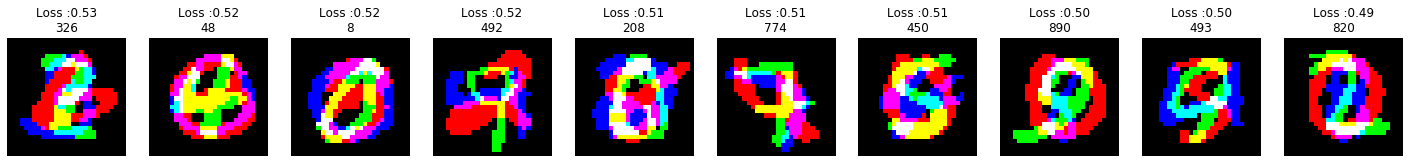

In [16]:
plt.figure(figsize=(25, 15))
for k, index in enumerate(worst_10):
    for i, data in enumerate(test_loader):
        if i == index:
            im = data[0].squeeze()
            label = data[1]
            plt.subplot(1, 10, k + 1)
            plt.imshow(im)
            plt.title(f"Loss :{anom_scores[index]:.2f}\n{label.item()}")
            # plt.title(label)
            plt.axis("off")